<a href="https://colab.research.google.com/github/MoBanerjee/InternshipAssignments/blob/main/Mohor_Polybee_Tech_Task_Automatic_Depth_Thresholding_FinalSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# assert torch.__version__.startswith("1.9")

# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html --quiet
# import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()
# from detectron2 import model_zoo
# from detectron2.config import get_cfg
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog, DatasetCatalog

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

!pip3 install scikit-spatial
import skspatial

!pip3 install pickle5
import pickle5 as pickle
import imutils
import io
import sys

2.0.1+cu118 False
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255319 sha256=e25c26fe5e3cf6321ca716b9357ac188a9846a2426b28445185c59750adac6b2
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


## Internal functions DO NOT MODIFY


In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
          return super().find_class(module, name)


def save_pickle(filepath, content):
    with open(filepath, 'wb') as pickle_file:
        pickle.dump(content, pickle_file, -1)


def load_pickle(filepath):
    with open(filepath, "rb") as input_file:
        annotations = CPU_Unpickler(input_file).load()
    return annotations


def mask_to_poly(mask):
    mask = np.array(mask).astype(np.uint8)
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts):
        c = max(cnts, key=cv2.contourArea)
    else:
        c = []
    return c


def poly_to_mask(polygon, im_shape):
    mask = np.zeros(im_shape)
    cv2.drawContours(mask, [polygon], -1, color=(255,255,255), thickness=-1)
    return mask.astype(bool)


def draw_annotation(image, bbox, polygon, thickness=2):
    top_left = (int(bbox[0]), int(bbox[1]))
    bot_right = (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(image, top_left, bot_right, (239,255, 0), thickness)
    cv2.drawContours(image, polygon, -1, (0,255,255), thickness)

#Helper Functions, Use them to visualise the images, depthmaps and annotations

In [3]:
def load_annotation(annotation_filename):
    '''
    Load annotations file to use for labelling
    INPUTS
    annotation_filename (str or path): Path to the annotation file
    OUTPUTS
    annotations (Dict): A dictionary containing annotations
    '''
    annotations = load_pickle(annotation_filename)
    return annotations


def label_image(image, annotations):
    '''
    labels annotations (bbox and masks) on the given image
    INPUTS
    image (np.array): Image to be labelled
    annotations (dict): Annotation dictionary
    '''
    for idx, annotation in annotations.items():
        bbox = annotation['bbox']
        polygon = annotation['polygon']
        draw_annotation(image, bbox, polygon)


def draw_image(image):
    '''
    Resizes and draws images for visualisation
    INPUTS
    image (np.array) Image to be drawn
    '''
    res = cv2.resize(image, (270,480))
    cv2_imshow(res)


def color_depthmap(depth_map):
    '''
    To visualise the depthmap, the function colors it like a heatmap
    INPUTS
    depth_map (np.array): The depthmap to be colored
    OUTPUTS
    depth_colored (np.array): Colored depthmap
    '''
    depth_colored = cv2.applyColorMap(cv2.convertScaleAbs(depth_map, alpha=10), cv2.COLORMAP_JET)
    return depth_colored

## Mount images here

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


!unzip -q "/content/drive/MyDrive/Polybee/TaskDataset.zip"

Mounted at /content/drive/


##Example Data visualisation

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])
<class 'dict'>
dict_keys(['score', 'class', 'bbox', 'area', 'polygon', 'drawpoly'])


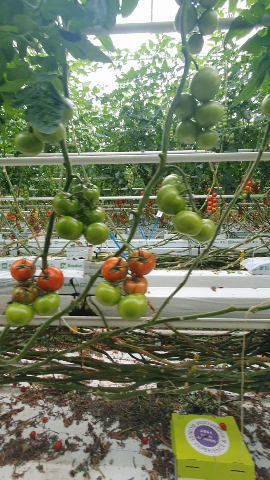

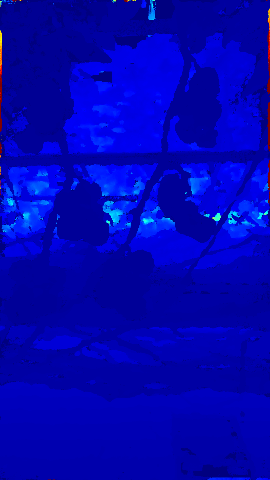

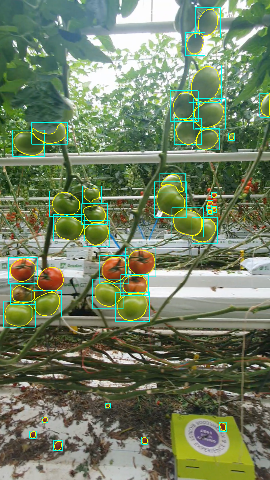

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68])
<class 'dict'>
dict_keys(['score', 'class', 'bbox', 'area', 'polygon', 'drawpoly'])


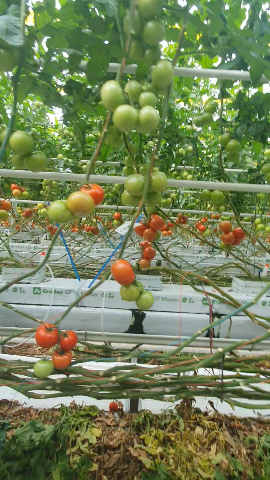

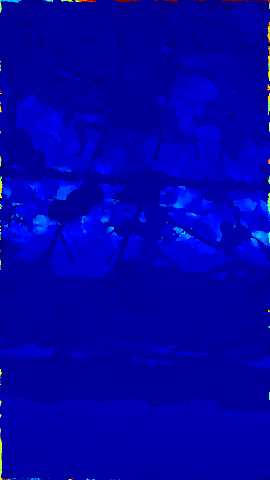

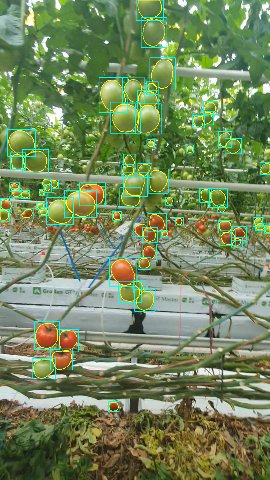

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118])
<class 'dict'>
dict_keys(['score', 'class', 'bbox', 'area', 'polygon'])


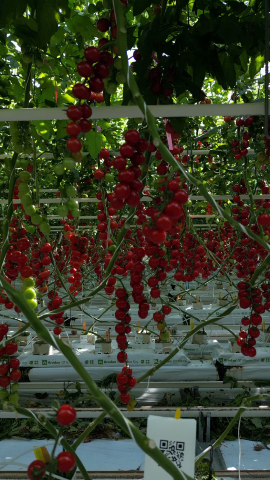

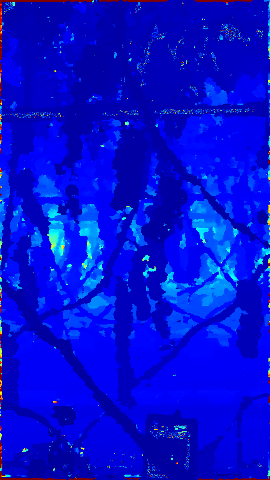

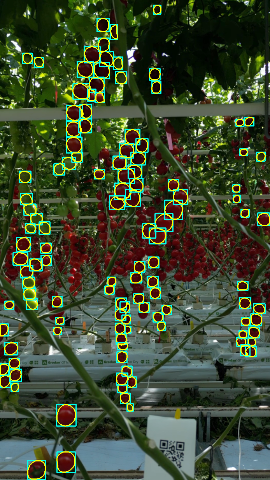

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])
<class 'dict'>
dict_keys(['score', 'class', 'bbox', 'area', 'polygon'])


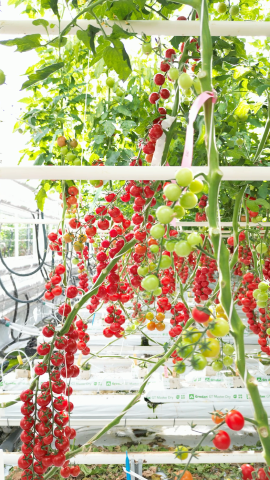

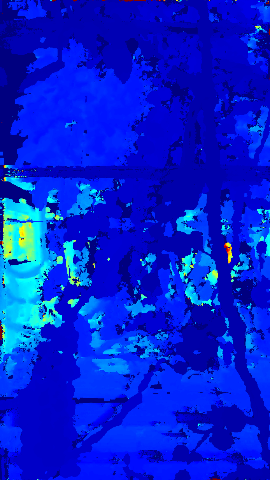

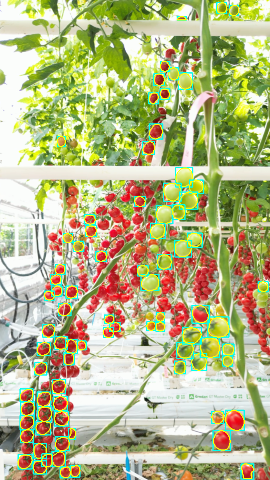

In [69]:
taskfolder = "/content/TaskDataset"
for filename in sorted([[f"{taskfolder}/{x[:-4]}", x[-4:]] for x in os.listdir(taskfolder) if x[-4:] == ".png" or x[-4:] == ".jpg"]):
  imagefile = f"{filename[0]}{filename[1]}"
  image = cv2.imread(imagefile)
  depthfile = f"{filename[0]}_depth.npy"
  depth = np.load(depthfile)

  annofile = f"{filename[0]}_annotation.pkl"
  anno = load_annotation(annofile)
  print(type(anno))
  print(anno.keys())
  print(type(anno[0]))
  print(anno[0].keys())
  draw_image(image)
  colored_depth = color_depthmap(depth)
  draw_image(colored_depth)
  label_image(image, anno)
  draw_image(image)


In [8]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039168 sha256=4e1916b2d6c118096aa4d6f173c3ce8ad7a42003cddd6559535a2466ee999d4b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.2
    Uninstalling Cython-3.0.2:
      Successfully uninstalled Cython-3.0.2


Function to determine depth threshold automatically and only count foreground tomatoes

In [35]:
import hdbscan

import math


def estimate_tomato_depth(annotation_dict, depth_map):

    class_label = annotation_dict['class']
    mask = annotation_dict['polygon']
    bbox = annotation_dict['bbox']


    if class_label == 0:

        mask = mask.reshape(-1, 2)
        centroid_x = int(np.mean([point[0] for point in mask]))
        centroid_y = int(np.mean([point[1] for point in mask]))
        if(centroid_y>=depth_map.shape[1]):
          centroid_y=depth_map.shape[1]-1
        centroid_depth=depth_map[centroid_x,centroid_y]
        return centroid_depth
    else:
        raise ValueError("The provided annotation is not for a tomato.")


def depth_threshold(img, depth, anno):
  # inputs : image, depth map, segmented tomato polygons
  # outputs : depth threshold in m, foreground tomato count, image with only foreground tomatoes labelled
    all_centroid_depths = []
    for annotation_dict in anno.values():
        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        all_centroid_depths.append(centroid_depth)


    centroid_depths_array = np.array(all_centroid_depths).reshape(-1, 1)


    clusterer = hdbscan.HDBSCAN(min_cluster_size=6)
    labels = clusterer.fit_predict(centroid_depths_array)


    foreground_labels = np.where(labels != -1)[0]


    foreground_depths = centroid_depths_array[foreground_labels]
    depth_threshold = np.mean(foreground_depths)

    count = 0
    annonew={}
    imdup=image.copy()
    e=0
    for annotation_dict in anno.values():

        centroid_depth = estimate_tomato_depth(annotation_dict, depth)
        if(centroid_depth<=depth_threshold):
          count=count+1
          annonew[e]=annotation_dict
          e=e+1
    label_image(imdup,annonew)
    return depth_threshold,count,imdup

Depth Threshold:  6.9161067
Number of foreground tomatoes annotated:  26


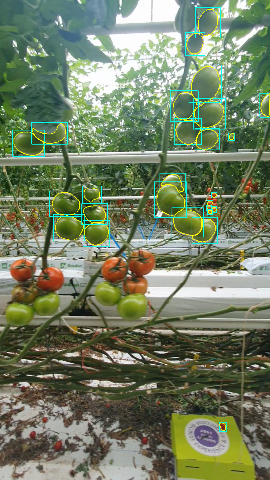

Depth Threshold:  0.94772166
Number of foreground tomatoes annotated:  29


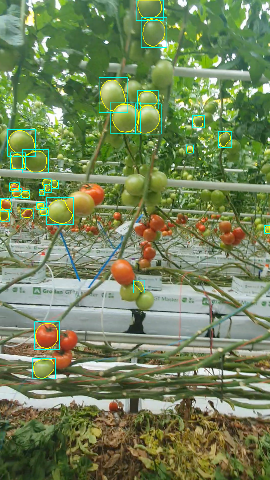

Depth Threshold:  3.4637496
Number of foreground tomatoes annotated:  72


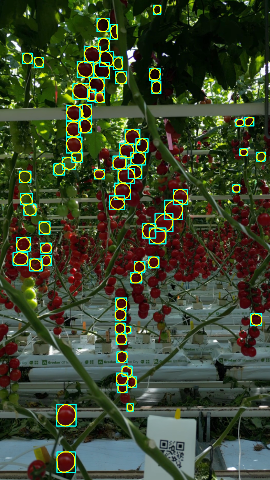

Depth Threshold:  1.6142696
Number of foreground tomatoes annotated:  44


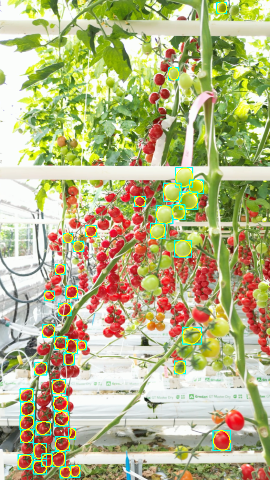

In [36]:
for filename in sorted([[f"{taskfolder}/{x[:-4]}", x[-4:]] for x in os.listdir(taskfolder) if x[-4:] == ".png" or x[-4:] == ".jpg"]):
  imagefile = f"{filename[0]}{filename[1]}"
  image = cv2.imread(imagefile)

  depthfile = f"{filename[0]}_depth.npy"
  depth = np.load(depthfile)

  annofile = f"{filename[0]}_annotation.pkl"
  anno = load_annotation(annofile)
  x,y,im=depth_threshold(image,depth,anno)
  print("Depth Threshold: ",x)
  print("Number of foreground tomatoes annotated: ",y)
  draw_image(im)

##Short Report on Part 1 of Task
First, I took the help of depth map and annotation visualisations to understand the format of depth and annotation information given. I inferred that the annotations data has been given as a dictionary containing a dictionary per annotated tomato. Each component dictionary has keys-: ['score', 'class', 'bbox', 'area', 'polygon']. The mask information was obtained from the polygon key.

Next, I used two functions to achieve the depth-based segmentation. I used centroid of tomato to estimate average depth of a tomato. HDBSCAN was the density-based clustering algorithm used to cluster the images into foreground and background tomatoes

##Algorithm Overview:
In estimate_tomato_depth function,first relevant information was extracted from the annotation_dict dictionary.The class label, polygon mask, and bounding box of the tomato were retrieved. A class label of 0 was a tomato. The mask array was reshaped into a 2D array with two columns, representing x and y coordinates.The mean of x and y coordinates from the mask array was computed to calculate the centroid of the tomato region. If the y-coordinate of the centroid was not within the bounds of the depth map, i.e if it exceeded, it was adjusted to the maximum valid y-coordinate.
Then the depth value from the depth_map at the calculated centroid coordinates was returned as the depth of the tomato. If the class label was not 0, a ValueError was raised indicating that the provided annotation was not for a tomato.

In the depth_threshold function, for each annotation, the estimate_tomato_depth function was called to get the depth of the tomato centroid. The obtained centroid depth was added to the all_centroid_depths list. Then this list was converted into a 2D numpy array, to prepare it for clustering. Then HDBSCAN clustering algorithm was applied to the centroid depths. The min_cluster_size parameter was set to 6. The labels corresponding to foreground tomatoes were identified by finding indices where the label was not -1 (assuming -1 represents noise/outliers). The depths of foreground tomatoes were extracted based on the identified labels and the depth threshold was calculated as the mean of the foreground depths.
A for loop was run to check whether the centroid depth of the initially annotated tomatoes were less than or equal to the calculated depth threshold. If the condition was met, the foreground tomato count was incremented and the corresponding annotation was added to the annonew dictionary. The label_image helper function was used to annotate a duplicate of the image using the modified annotation dictionary ( with only the foreground tomatoes annotated). Finally, the function returned the depth threshold, the count of foreground tomatoes, and the image with only foreground tomato annotations.

##Notes on Approach:
I initailly analysed and compared 10 different clustering algorithms namely ▶
1. KMeans
2. DBSCAN (Density-Based Spatial Clustering of Applications
   with Noise)
3. Gaussian Mixture Model (GMM)
4. Affinity Propagation
5. HDBSCAN (Hierarchical DBSCAN)
6. OPTICS (Ordering Points To Identify the Clustering
   Structure)
7. Birch (Balanced Iterative Reducing and Clustering using
   Hierarchies)
8. Agglomerative Clustering
9. Mean Shift Clustering
10. Spectral Clustering

Upon comparing results, HDBSCAN yielded outcome (number of foreground tomatoes) closest to the ground truth provided for the test cases. Thus, it was chosen. DBSCAN was yielding fairly good outcomes for some test cases but very erroneous outcomes for others. But HDBSCAN performed much better than it. This maybe due to reasons like HDBSCAN can handle clusters with varying densities unlike DBSCAN and the tomatoes may have different depths and densities. HDBSCAN also shows robustness to noise, efficient memory usage, hierarchical clustering capabilities, adaptive density estimation and identification of outliers. Noise handling is necessary in a dataset such as the one given as there might be cases where some annotations or depth estimations might be erroneous.

##Limitations:
1. Dependency on Annotations: Accuracy heavily relies on precise annotations.
2. Sensitivity to Hyperparameters: Performance might be affected by hyperparameters, e.g., min_cluster_size in HDBSCAN.
3. Limited Robustness to Occlusion: Doesn't explicitly handle partially blocked tomatoes.

####Improvements: Occlusion Handling, Hyperparameter Analysis






Function to determine tomato depth correctly even if tomato is occluded by a leaf or branch (mask could include leaf in tests used by us)

In [64]:
def occ_tomato_depth(img, depth, anno):
     #inputs : image, depth, segmented tomato polygons
     #outputs : list of tomatoes and their depths in m, image with area used for depth estimation marked

    tomato_depths = []
    imdup=image.copy()

    for annotation_dict in anno.values():
        class_label = annotation_dict['class']


        if class_label == 0:

            mask = annotation_dict['polygon']
            mask = mask.astype(int)


            mask = mask.reshape(-1, 2)
            centroid_x = int(np.mean([point[0] for point in mask]))
            centroid_y = int(np.mean([point[1] for point in mask]))

            if centroid_y >= depth.shape[1]:
                centroid_y = depth.shape[1] - 1


            centroid_depth = depth[centroid_x, centroid_y]
            depthn=centroid_depth

            leaf_mask = annotation_dict.get('leaf_mask', None)
            if leaf_mask is not None:
                leaf_centroid = np.mean(np.argwhere(leaf_mask), axis=0)
                distance = np.linalg.norm(np.array([centroid_x, centroid_y]) - leaf_centroid)
                if distance < 30:
                    shifted_mask = np.roll(mask, int(distance), axis=(0, 1))
                    annotation_dict["polygon"]=mask_to_poly(shifted_mask)
                    valid_depth_points = depth[shifted_mask[:, 0], shifted_mask[:, 1]]
                    if len(valid_depth_points) > 0:
                        depthn = np.mean(valid_depth_points)
                    else:
                        depthn = None


            tomato_depths.append(depthn)
    label_image(imdup,anno)

    return tomato_depths,imdup


##Short Note on Part 2 of Task (Bonus Q)
The algorithm iterated over the tomato annotations in the image. For each annotation, it first checked the class label to make sure that it is a tomato. If it was a tomato, then the centroid of the tomato was calculated.

Next, the algorithm checked if the centroid was outside of the bounds of the depth map. If it was, then the centroid was set to be the edge of the depth map.

It then calculated the depth at the centroid. This was the depth of the tomato.

Then, it checked if the tomato had a leaf mask (occlusion) associated with it. If it had, the algorithm calculated the distance between the centroid of the tomato and the centroid of the leaf mask. If this distance was less than 30 pixels, the tomato mask was shifted by the distance.

Then the mean depth of the pixels in the shifted tomato mask was calculated. This was the new depth of the tomato which was appended to the list of tomato depths.

Finally, the image was labelled with the new tomato annotations consisting of shifted masks.

##Limitations
1. Doesn't account for occlusion by other objects
2. Dependant on accuracy of annotations and depth map

##Improvements
1. Account for more objects that can block the tomatoes

Depths of Tomatoes:  [18.382765, 37.650578, 45.332058, 60.855957, 5.466684, 2.1944718, 72.12249, 20.637037, 2.7444115, 3.500759, 2.6259143, 60.57049, 0.6576412, 0.0, 21.857876, 4.496315, 23.815643, 63.51317, 2.0485833, 2.0652442, 2.661531, 25.08694, 0.0, 0.6292277, 4.669276, 21.668219, 0.64852524, 4.1092267, 3.7456338, 2.4880528, 0.59394443, 21.540447, 0.6104926, 18.187372, 2.253707, 2.3339233, 5.0910845, 43.533176, 2.2561998, 0.56207746, 2.2439637]


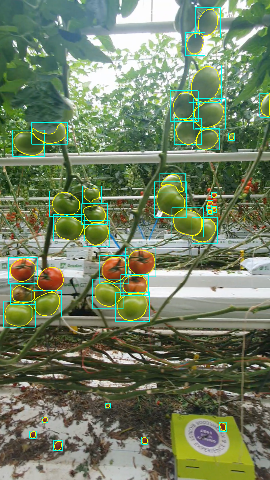

Depths of Tomatoes:  [1.816313, 14.400383, 0.54721016, 0.0, 0.49878576, 1.0591823, 0.0, 1.9109867, 1.0296485, 0.0, 1.8803715, 0.71303415, 1.8705463, 1.9048373, 14.576706, 1.7254966, 13.730066, 0.0, 1.2669832, 0.0, 0.97859454, 1.1011155, 1.2691816, 0.58623743, 1.1030184, 0.6027138, 1.0692261, 0.5569727, 1.0977014, 0.5632518, 18.176172, 2.4201107, 2.49275, 3.2033575, 1.0763991, 1.1066712, 0.93891317, 0.7981319, 0.0, 1.0142995, 0.0, 0.6023601, 0.6018558, 0.0, 1.0669811, 0.56504816, 0.5892505, 0.60168296, 1.9599402, 0.95912856, 0.6137177, 0.5972469, 1.7324967, 1.0826094, 0.6419544, 1.9297435, 0.5987471, 0.53813064, 0.88050133, 2.0426474, 0.0, 2.182458, 1.7404351, 3.488324, 1.0989666, 1.1674068, 1.073428, 1.0463957, 2.3032017]


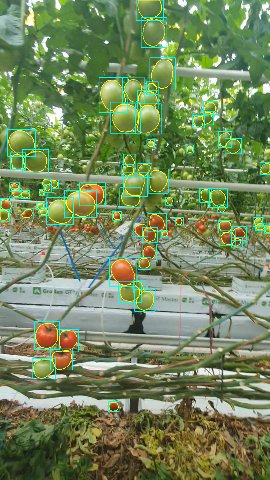

Depths of Tomatoes:  [1.1031064, 1.8084525, 0.9134732, 0.89078957, 1.2391361, 3.175399, 0.95415556, 0.8873414, 1.5378546, 3.3668725, 3.2669787, 1.6556857, 10.143789, 1.3616855, 4.1941466, 0.99763066, 2.8616948, 1.0797677, 1.8274046, 3.4761868, 1.3971529, 1.4321744, 1.4722009, 7.0874057, 0.9342233, 8.904417, 7.570446, 3.3758585, 4.763958, 3.011664, 1.4830247, 12.607931, 0.9344517, 9.012704, 1.2377993, 1.2528781, 9.220033, 7.5969987, 1.3358545, 6.6816998, 5.3968487, 1.43318, 3.2172325, 0.86789787, 1.267128, 1.6127695, 12.41204, 1.3192295, 3.1602376, 8.085256, 3.021559, 7.260662, 1.7140955, 8.539307, 1.3958576, 3.1191108, 1.6630249, 3.4270344, 17.525122, 60.196053, 0.91429645, 9.706797, 6.327299, 33.249428, 1.2749788, 1.5231941, 6.677483, 0.8905415, 1.4658278, 3.129615, 3.1602376, 5.468988, 1.2442393, 6.797609, 9.425755, 1.3955605, 1.3698454, 7.148218, 14.84868, 10.554845, 1.6359347, 0.93828684, 3.183336, 1.1823266, 0.9202751, 3.2172325, 5.2475266, 7.3492637, 7.148218, 0.95535475, 1.19079

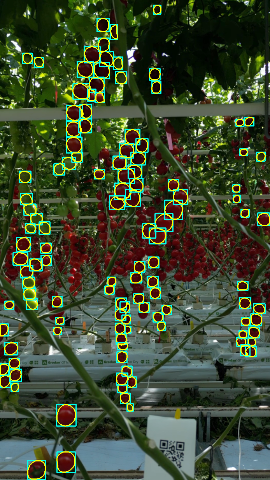

Depths of Tomatoes:  [1.0810776, 0.0, 4.6509614, 1.0836226, 1.5805281, 2.03766, 3.8245332, 1.0742291, 1.1291404, 1.1256142, 7.6415415, 6.862728, 3.888232, 1.8512169, 7.9164925, 1.4367152, 4.3504896, 1.5447655, 1.8593253, 3.95364, 0.0, 3.9743645, 1.0658319, 0.0, 0.0, 0.0, 0.0, 0.0, 4.6440816, 1.4737455, 0.0, 9.710034, 0.0, 0.0, 4.209943, 7.863196, 1.9188861, 1.9751427, 1.980518, 4.820996, 1.49977, 1.9193815, 4.0936804, 0.0, 4.825958, 0.0, 4.7329125, 3.8123822, 3.8594677, 0.0, 0.0, 0.0, 1.7831497, 3.640023, 2.0050166, 1.6105769, 0.0, 6.903045, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5919118, 1.4381479, 0.0, 0.0, 9.30343, 0.0, 4.0936804, 1.9521916, 1.9565858, 1.7980785, 0.0, 5.029716, 1.809646, 1.9565858, 0.0, 0.0]


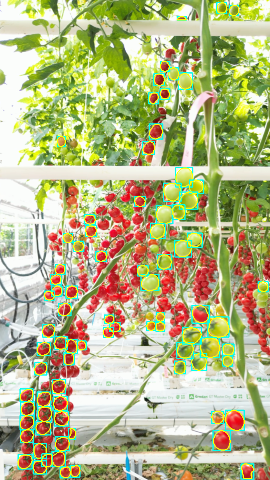

In [71]:
for filename in sorted([[f"{taskfolder}/{x[:-4]}", x[-4:]] for x in os.listdir(taskfolder) if x[-4:] == ".png" or x[-4:] == ".jpg"]):
  imagefile = f"{filename[0]}{filename[1]}"
  image = cv2.imread(imagefile)

  depthfile = f"{filename[0]}_depth.npy"
  depth = np.load(depthfile)
  annofile = f"{filename[0]}_annotation.pkl"
  anno = load_annotation(annofile)

  x,imshifted=occ_tomato_depth(image,depth,anno)
  print("Depths of Tomatoes: ",x)
  draw_image(imshifted)



##Citations
1. https://www.freecodecamp.org/news/8-clustering-algorithms-in-machine-learning-that-all-data-scientists-should-know/

2. https://www.geeksforgeeks.org/thresholding-based-image-segmentation/

3. https://insights.daffodilsw.com/blog/top-5-clustering-algorithms-in-machine-learning